# 作业第8周：强化学习

### 理解Q学习算法，练习Keras实现 DQN网络  (！注意使用DeepL-3.10服务！)
#### 要求：
1）设计DQN网络，生成policy_net和target_net<BR>
2）调整Q学习算法参数，提高倒立摆保持时间。(可以尝试利用env提供的信息改进reward策略)

#### 考核办法：
训练100epoch后的性能表现,取保持时间最大的一次（80为及格线，160以上优秀）

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,1024)
# import os
# os.environ["PATH"]=os.environ["PATH"]+':/usr/local/cuda/bin'

Thu Jun 15 20:42:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 42%   49C    P2   112W / 350W |  15145MiB / 24268MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   

In [2]:
%matplotlib notebook
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf
#Windows调试时!!删除下面2行！！
from pyvirtualdisplay import Display
Display().start()

env = gym.make('CartPole-v0').unwrapped
env.reset()


array([ 0.03985491, -0.00487207,  0.01525217, -0.04923961], dtype=float32)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### 请在下面设计DQN网络结构
输入：图片shape=(40, 90, 3,)<BR>
输出：（2，）

In [4]:
#Refer：https://keras.io/api/layers/
num_actions = 2

def create_q_model():
    num_actions = 2
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(40, 90, 3,))
    model = keras.Sequential()

    # 添加卷积层和池化层
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 90, 3,)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 展平特征图
    model.add(layers.Flatten())

    # 添加全连接层
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_actions))  # 输出层，输出动作数量的节点

    return model
    #return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
model_target = create_q_model()
model.summary()

2023-06-15 20:42:57.392352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 20:42:58.088436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 44, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 42, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 21, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 19, 64)         36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 9, 64)         0

In [5]:

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. 
    screen = env.render(mode='rgb_array')
    # Cart is in the lower half, so strip off the top and bottom of the screen
    screen_height, screen_width,_ = screen.shape
    rawscreen=screen = screen[int(screen_height*0.4):int(screen_height * 0.8),:,:]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, slice_range, :]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen=tf.image.resize(screen,(40,90),method='bicubic')/255.0
    return screen,rawscreen
    

### 后续代码可以根据需要进行调参或修改细节

In [6]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.8
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
memory = ReplayMemory(10000)

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
# Using huber loss for stability
loss_function = keras.losses.Huber()


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        action_probs =model(tf.expand_dims(state, 0), training=False)
        action = tf.argmax(action_probs[0]).numpy()
        return action
    else:
        return random.randrange(num_actions)


episode_durations = []
def plot_durations():
    ax1_2.clear()
    ax1_2.set_title('Training...')
    ax1_2.set_xlabel('Episode')
    ax1_2.set_ylabel('Duration')
    ax1_2.plot(episode_durations)
    fig1.canvas.draw()


In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask =np.array( tuple(map(lambda s: s is not None,       batch.next_state)))
#     print(non_final_mask)
    non_final_next_states = tf.stack([s for s in batch.next_state
                                                if s is not None])
#     print(non_final_next_states.shape)
    state_sample = tf.stack(batch.state)

    action_sample =np.array( batch.action)
    rewards_sample =np.array(batch.reward)
    
    future_rewards = np.zeros(BATCH_SIZE,dtype='float32')
    future_rewards[non_final_mask] =tf.reduce_max( model_target.predict(non_final_next_states,verbose=0), axis=1)

    # Q value = reward + discount factor * expected future reward
    updated_q_values = rewards_sample + GAMMA * future_rewards

    # Create a mask so we only calculate loss on the updated Q-values
    masks = tf.one_hot(action_sample, num_actions)

    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = model(state_sample)

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))



<IPython.core.display.Javascript object>


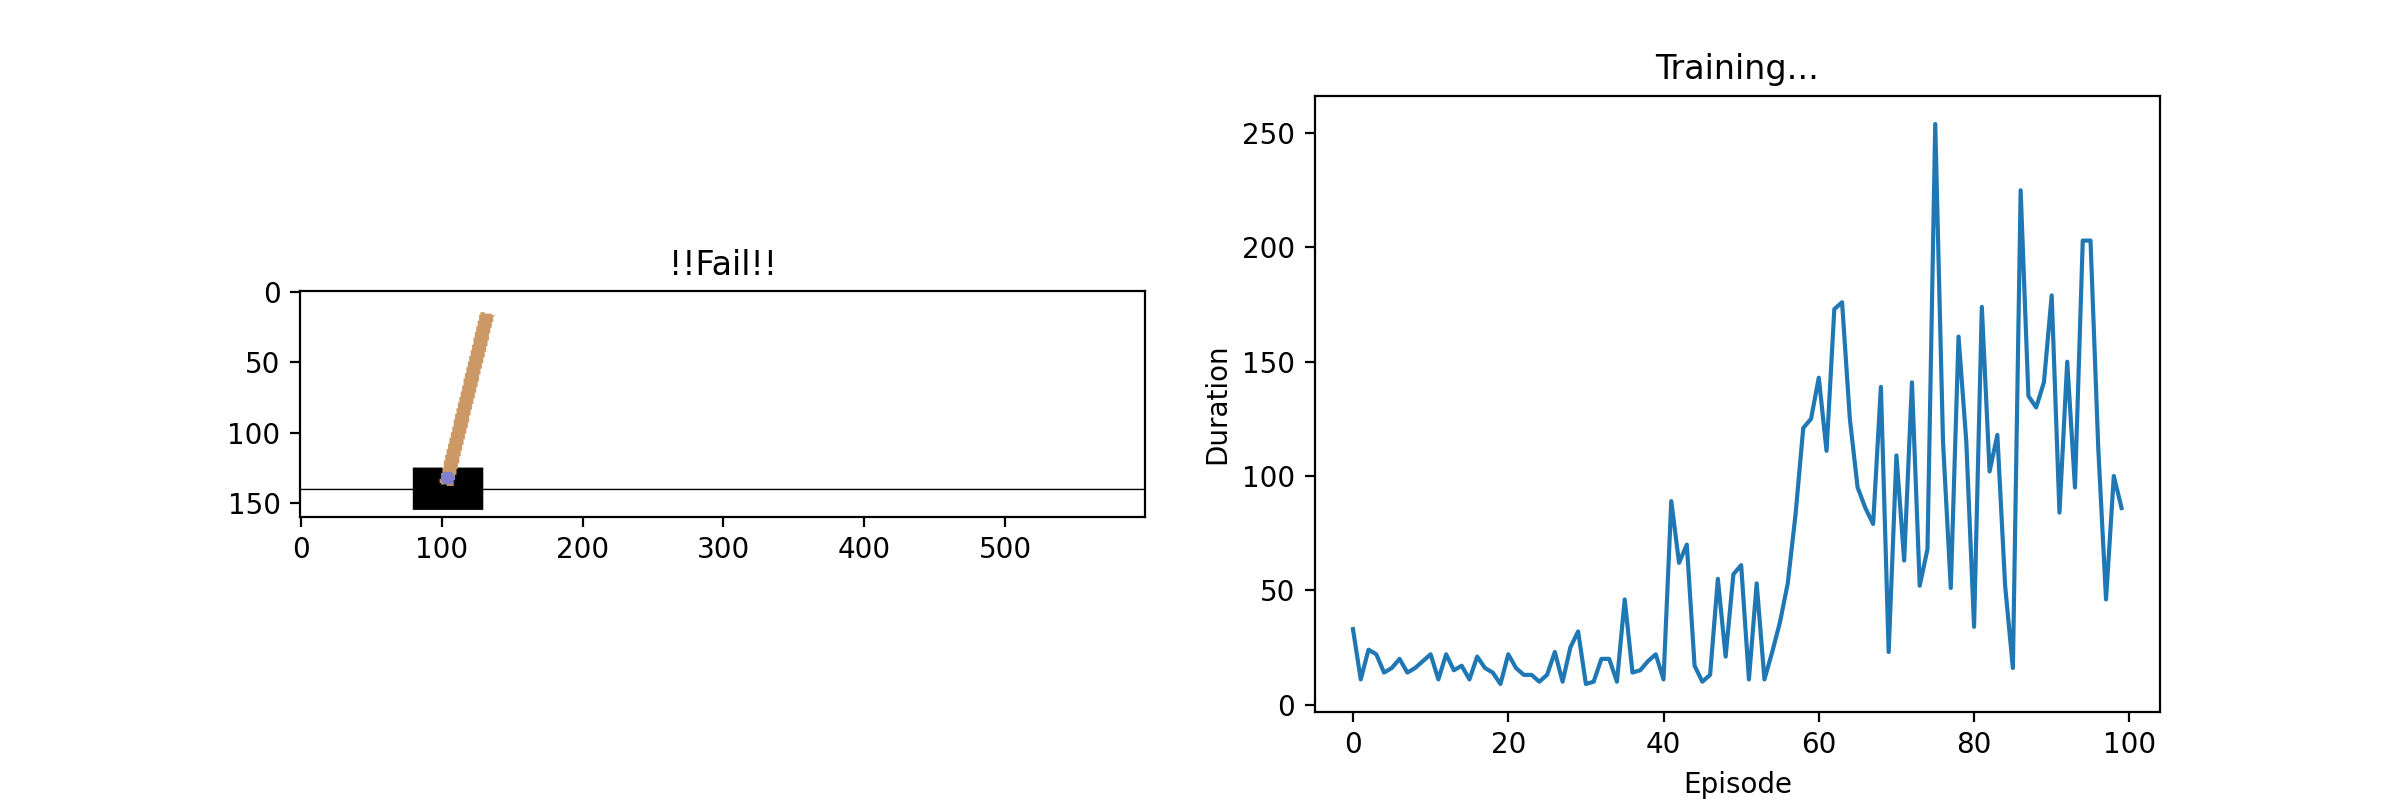

2023-06-15 20:43:00.231649: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-15 20:43:02.492331: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Complete
最好成绩： 254


In [8]:
# import warnings
# warnings.filterwarnings('ignore')

plt.ion()
fig1=plt.figure(figsize=(12,4))
ax1_1 = fig1.add_subplot(121)
ax1_2 = fig1.add_subplot(122)
init_screen,rawscreen = get_screen()
ax1_1.imshow(rawscreen)
fig1.canvas.draw()

num_episodes = 100
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = init_screen
    current_screen,_ = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        ss, reward, done, _ = env.step(action)
        
        ###尝试调整reward策略
        #reward=......
        
        # Observe new state
        last_screen = current_screen
        current_screen,rawscreen = get_screen()

        ###以下显示动画会较严重影响运行速度，建议调试期间去除
        ax1_1.clear()
        if done:
            ax1_1.set_title('!!Fail!!')
        else:
            ax1_1.set_title('score:'+str(t+1))
        ax1_1.imshow(rawscreen)
        fig1.canvas.draw()
        plt.pause(0.001)
        ###显示动画会较严重影响运行速度，建议调试期间去除
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        model_target.set_weights(model.get_weights())

print('Complete')
# env.render()
env.close()
plt.ioff()
plt.show()
print('最好成绩：', max(episode_durations))

#### 总结说明
此处说明关于模型设计与模型训练（参数设置、训练和调优过程）的心得与总结

1. 尝试使用线性层进行网络预测
2. 采用三层卷积神经网络进行训练，取代了线性层的叠加，对于图的信息提取能更加充分。
3. 采取了最大池化的策略，便于强调位置特征
4. 尝试调整卷积神经网络的结构，对比实验结果
5. 尝试调整reward的优化策略

最后的实验结果中，成绩的波动性还比较大，有一定过的优化空间。